# Dijkstra's Algorithm

Dijkstra guarantees the shortest path by exploring nodes in order of their cost from the start.

## The Core Idea

Imagine you're distributing packages. You always deliver to the closest unvisited address first. This ensures you find the shortest route to each location.

**Dijkstra does the same thing with graph nodes.**

## How It Works

Maintain a priority queue of nodes sorted by **cost from start**.

**Always expand the cheapest node.**

```
Priority Queue at each step:
[(1, A), (3, B), (5, C)]  ← Always pick the node with cost 1
```

This greedy approach works because:
1. Once you visit a node, you've found its shortest path
2. Any future path to that node must go through more expensive nodes first

## Difference from A*

**Dijkstra:** Priority = g(n) only (cost from start)
**A*:** Priority = g(n) + h(n) (cost from start + estimate to goal)

Dijkstra explores uniformly. A* explores toward the goal.

Both guarantee shortest path, but A* finds it faster.

In [1]:
import heapq
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict

%matplotlib inline

In [2]:
class WeightedGrid:
    """Grid where cells can have different costs"""
    def __init__(self, width, height, obstacles, start, goal, terrain_costs=None):
        self.width = width
        self.height = height
        self.obstacles = set(obstacles)
        self.start = start
        self.goal = goal
        # terrain_costs: dict of (x,y) -> cost multiplier
        self.terrain_costs = terrain_costs or {}
    
    def neighbors(self, pos):
        x, y = pos
        candidates = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        return [
            (nx, ny) for nx, ny in candidates
            if 0 <= nx < self.width and 0 <= ny < self.height
            and (nx, ny) not in self.obstacles
        ]
    
    def cost(self, from_pos, to_pos):
        """Cost to move to a position (terrain dependent)"""
        base_cost = 1
        terrain_multiplier = self.terrain_costs.get(to_pos, 1)
        return base_cost * terrain_multiplier

print("Weighted grid created")

Weighted grid created


## Dijkstra's Algorithm Step by Step

**Setup:**
```python
pq = [(0, start)]         # Priority queue: (cost, node)
distances = {start: 0}    # Best known distance to each node
came_from = {}            # Parent tracking
```

**Main Loop:**

**Step 1:** Pop the cheapest node
```python
current_cost, current = heappop(pq)
```

**Step 2:** Skip if already visited with lower cost
```python
if current_cost > distances[current]:
    continue  # Already found better path
```

**Step 3:** For each neighbor, try to improve its distance
```python
for neighbor in neighbors(current):
    new_cost = distances[current] + edge_cost(current, neighbor)
    
    if new_cost < distances[neighbor]:  # Found cheaper path
        distances[neighbor] = new_cost
        heappush(pq, (new_cost, neighbor))
        came_from[neighbor] = current
```

**Step 4:** Repeat until all reachable nodes visited

## Example Walkthrough

```
Start at A, edges: A→B(1), A→C(4), B→C(2), B→D(5), C→D(1)

Step 1:
  PQ: [(0, A)]
  Visit A, add neighbors
  PQ: [(1, B), (4, C)]
  Distances: {A:0, B:1, C:4}

Step 2:
  PQ: [(4, C)]  (popped B)
  From B, can reach C for 1+2=3 (better than 4!)
  Update: C now costs 3
  PQ: [(3, C), (4, C_old), (6, D)]
  
Step 3:
  PQ: [(4, C_old), (6, D)]  (popped updated C at 3)
  From C, can reach D for 3+1=4 (better than 6!)
  Update: D now costs 4
  PQ: [(4, D), (4, C_old), (6, D_old)]

Step 4:
  Done! Shortest paths found:
  A→B: 1
  A→C: 3 (via B)
  A→D: 4 (via B→C)
```

Notice how we keep updating distances when we find cheaper paths.

In [3]:
def dijkstra(grid):
    """
    Dijkstra's algorithm - no heuristic, pure cost-based
    """
    open_set = []
    counter = 0
    heapq.heappush(open_set, (0, counter, grid.start))
    counter += 1
    
    came_from = {}
    cost_so_far = defaultdict(lambda: float('inf'))
    cost_so_far[grid.start] = 0
    
    visited = []
    
    while open_set:
        current_cost, _, current = heapq.heappop(open_set)
        visited.append(current)
        
        if current == grid.goal:
            # Reconstruct path
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], visited, cost_so_far[grid.goal]
        
        for neighbor in grid.neighbors(current):
            new_cost = cost_so_far[current] + grid.cost(current, neighbor)
            
            if new_cost < cost_so_far[neighbor]:
                cost_so_far[neighbor] = new_cost
                came_from[neighbor] = current
                heapq.heappush(open_set, (new_cost, counter, neighbor))
                counter += 1
    
    return None, visited, float('inf')

print("Dijkstra implementation ready")

Dijkstra implementation ready


In [4]:
def visualize_dijkstra(grid, path, visited, total_cost):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(0, grid.width)
    ax.set_ylim(0, grid.height)
    ax.set_aspect('equal')
    
    for x in range(grid.width):
        for y in range(grid.height):
            color = 'white'
            alpha = 1.0
            
            if (x, y) in grid.obstacles:
                color = 'black'
            elif (x, y) in grid.terrain_costs:
                # Show terrain cost as color intensity
                cost = grid.terrain_costs[(x, y)]
                color = 'orange'
                alpha = min(cost / 5, 1.0)
            
            if (x, y) in visited and (x, y) not in [grid.start, grid.goal]:
                if color == 'white':
                    color = 'lightblue'
                    alpha = 0.5
            
            rect = patches.Rectangle((x, y), 1, 1,
                                     linewidth=1, edgecolor='gray',
                                     facecolor=color, alpha=alpha)
            ax.add_patch(rect)
            
            # Show terrain cost
            if (x, y) in grid.terrain_costs:
                cost = grid.terrain_costs[(x, y)]
                ax.text(x+0.5, y+0.5, f'{cost}', ha='center', va='center',
                       fontsize=8, color='darkred', fontweight='bold')
    
    # Draw path
    if path:
        for i in range(len(path) - 1):
            x1, y1 = path[i]
            x2, y2 = path[i+1]
            ax.arrow(x1+0.5, y1+0.5, x2-x1, y2-y1,
                    head_width=0.2, head_length=0.2,
                    fc='red', ec='red', linewidth=2, length_includes_head=True)
    
    # Mark start and goal
    start_x, start_y = grid.start
    goal_x, goal_y = grid.goal
    ax.text(start_x+0.5, start_y+0.5, 'S', ha='center', va='center',
           fontsize=20, fontweight='bold', color='green')
    ax.text(goal_x+0.5, goal_y+0.5, 'G', ha='center', va='center',
           fontsize=20, fontweight='bold', color='red')
    
    ax.set_xticks(range(grid.width))
    ax.set_yticks(range(grid.height))
    ax.grid(True, alpha=0.3)
    
    if path:
        ax.set_title(f'Dijkstra | Cost: {total_cost:.1f} | Nodes Explored: {len(visited)}',
                    fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("Visualization ready")

Visualization ready


## Example: Terrain with Different Costs

Orange cells cost more to traverse. Dijkstra finds the cheapest path, not necessarily the shortest.

Path cost: 17
Path length: 12 steps
Nodes explored: 95


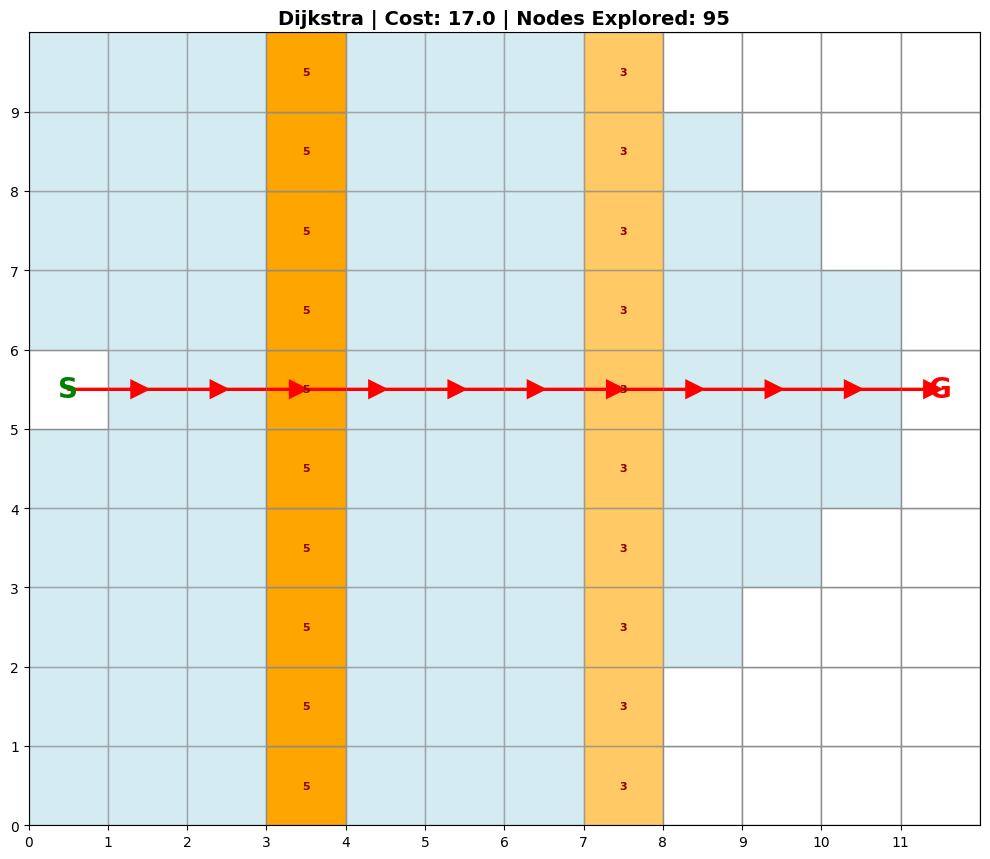

In [5]:
# Create expensive terrain
expensive_terrain = {
    (3, y): 5 for y in range(10)  # Vertical expensive strip
}
expensive_terrain.update({
    (7, y): 3 for y in range(10)  # Another strip
})

grid = WeightedGrid(
    width=12,
    height=10,
    obstacles=[],
    start=(0, 5),
    goal=(11, 5),
    terrain_costs=expensive_terrain
)

path, visited, cost = dijkstra(grid)
print(f"Path cost: {cost}")
print(f"Path length: {len(path)} steps")
print(f"Nodes explored: {len(visited)}")

visualize_dijkstra(grid, path, visited, cost)

## What Just Happened?

Look at the blue nodes - they spread uniformly from the start. Dijkstra explores in all directions equally because it has no heuristic to guide it.

**The visit order shows a circle** expanding from the start. Every node at distance d is visited before any node at distance d+1.

This is different from A*, which would focus exploration toward the goal.

Grid world created
A* implementation ready
Visualization ready
Running A*...
Path found! Length: 21
Nodes explored: 58


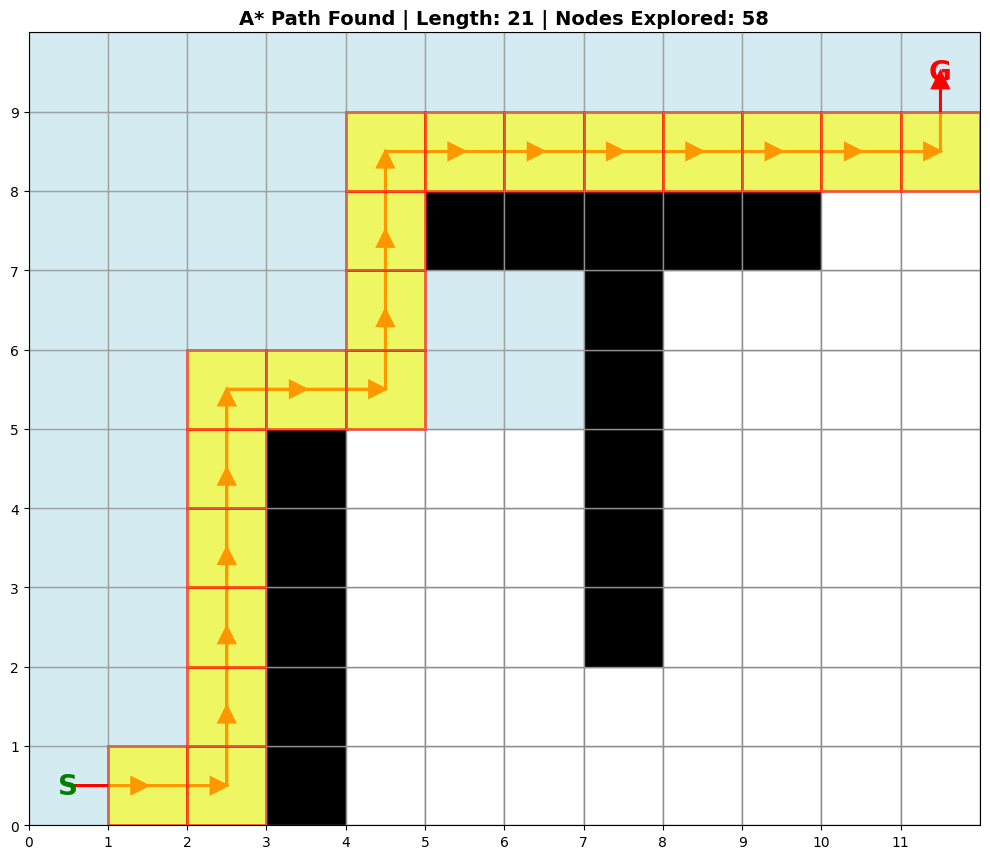

Open space:
Path length: 19, Nodes explored: 100


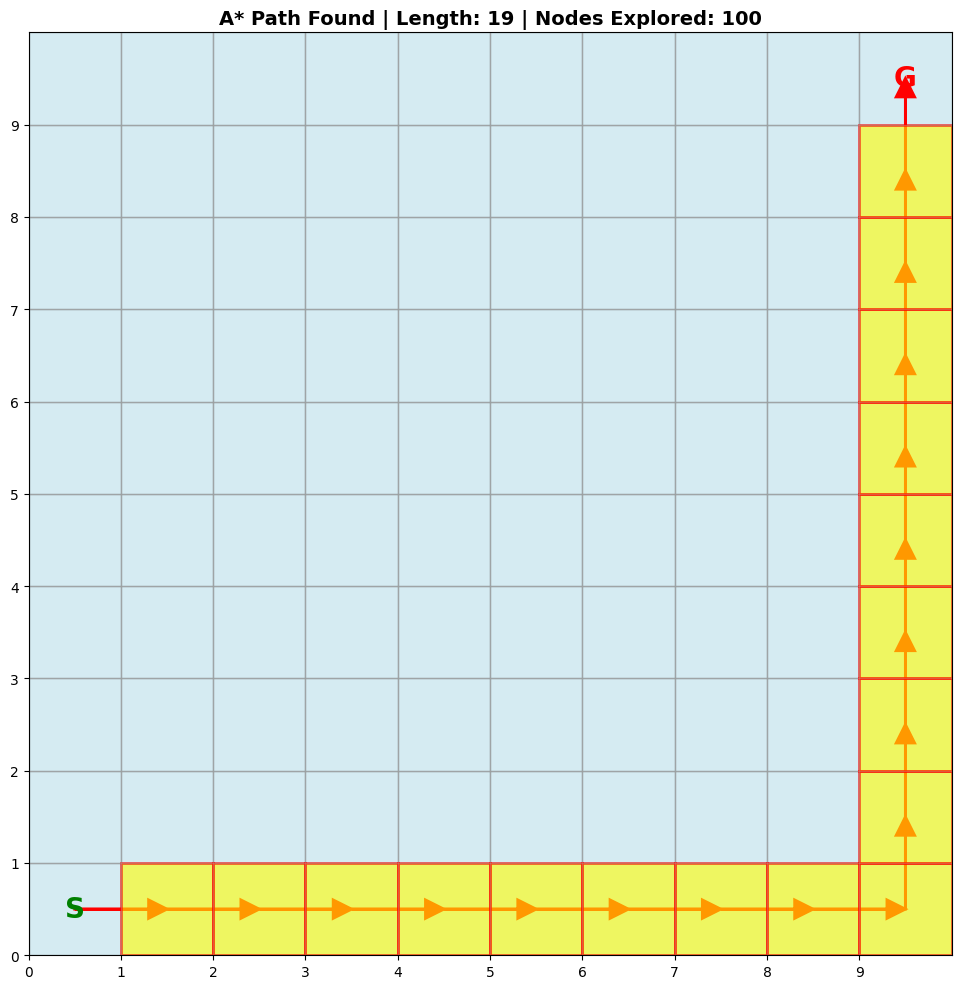

Long barrier:
Path length: 20, Nodes explored: 76


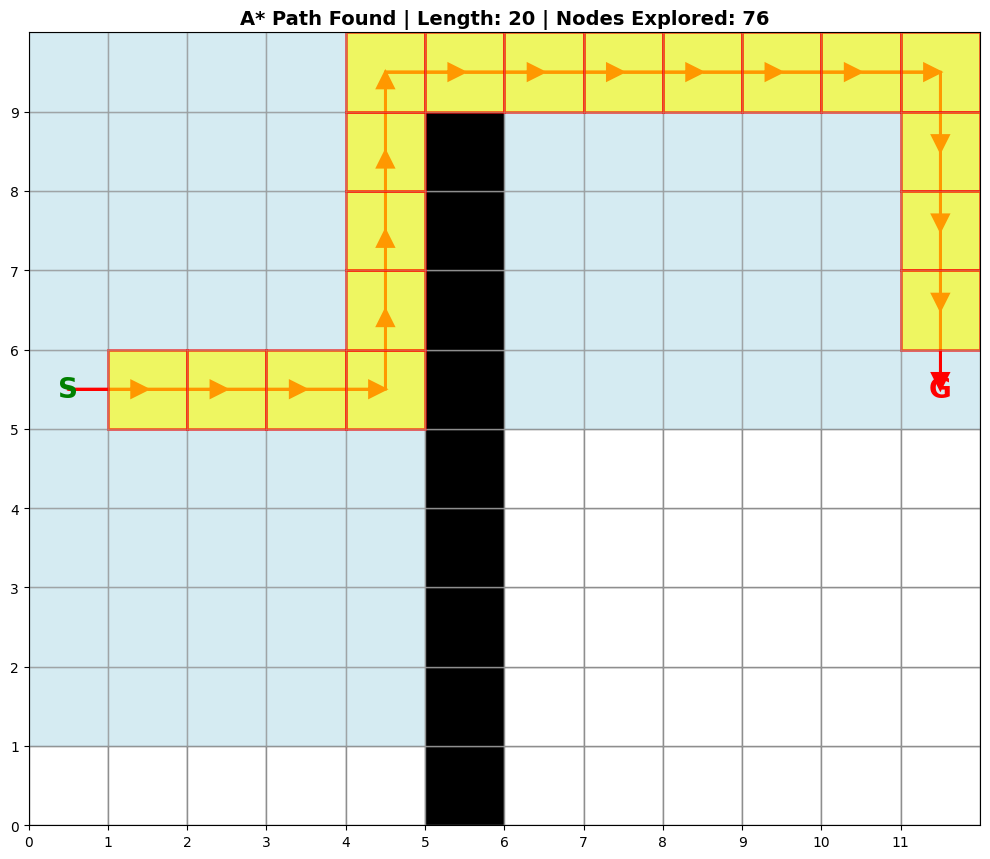

Dijkstra:
  Nodes explored: 92
  Path length: 18

A*:
  Nodes explored: 60
  Path length: 18

A* explored 32 fewer nodes!


In [6]:
# Compare on same problem
%run AStar_Search.ipynb

obstacles = [(5, y) for y in range(8)]

# Dijkstra version
grid_d = WeightedGrid(12, 10, obstacles, (0, 5), (11, 5))
path_d, visited_d, cost_d = dijkstra(grid_d)

# A* version
grid_a = GridWorld(12, 10, obstacles, (0, 5), (11, 5))
path_a, visited_a = a_star(grid_a)

print("Dijkstra:")
print(f"  Nodes explored: {len(visited_d)}")
print(f"  Path length: {len(path_d)}")

print("\nA*:")
print(f"  Nodes explored: {len(visited_a)}")
print(f"  Path length: {len(path_a)}")

print(f"\nA* explored {len(visited_d) - len(visited_a)} fewer nodes!")

## When to Use Dijkstra

**Use Dijkstra when:**
- Need shortest path to multiple goals (finds all distances from start)
- Have weighted edges with varying costs
- No good heuristic available
- Graph isn't spatial (no meaningful distance metric)

**Don't use when:**
- Single goal with good heuristic → use A*
- Just need any path → use BFS/DFS
- Negative edge weights → use Bellman-Ford

**Key difference from A*:**
- Dijkstra explores uniformly in all directions (no heuristic guidance)
- A* focuses search toward goal
- Dijkstra explores more nodes but is simpler

**Complexity:**
- Time: O((V + E) log V) with binary heap
- Space: O(V) where V is number of nodes